# Target configuration

In [1]:
# Target configuration
conf = {
    
    # Target type
    "platform"    : 'linux',
    "board"       : "sabre",
    
    # Login credentials
    "host"        : "192.168.10.162",
    "username"    : "root",
    "password"    : "temppwd",

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "sched_wakeup_new",
             "sched_wakeup",
             "sched_deadline_suspend",
             "sched_deadline_replenish",
             "cpu_frequency",
             "sched_dl_grub",
             "sched_load_avg_task",
         ],
         "buffsize" : 10240
    },
}

cpu_number = 4

In [2]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
# Execute this cell to enabled devlib debugging statements
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [4]:
# Generate plots inline
%pylab inline

# Other python modules required by this notebook
import json
import os
import shutil

Populating the interactive namespace from numpy and matplotlib


In [5]:
 #Support to access the remote target
from env import TestEnv

# Initialize a test environment
te = TestEnv(conf)
target = te.target

/usr/lib/python2.7/dist-packages/gtk-2.0/gtk/__init__.py:57: GtkWarning: could not open display
  warnings.warn(str(e), _gtk.Warning)
01:42:22  WARNING : Unusual max capacity (1023), overriding capacity_scale
01:42:22  INFO    : Using base path: /lisa
01:42:22  INFO    : Loading custom (inline) target configuration
01:42:22  DEBUG   : Target configuration {'username': 'root', 'ftrace': {'buffsize': 10240, 'events': ['sched_switch', 'sched_wakeup_new', 'sched_wakeup', 'sched_deadline_suspend', 'sched_deadline_replenish', 'cpu_frequency', 'sched_dl_grub', 'sched_load_avg_task']}, 'platform': 'linux', 'host': '192.168.10.162', 'board': 'sabre', 'password': 'temppwd', 'tools': ['taskset', 'trace-cmd']}
01:42:22  DEBUG   : Trying to load board descriptor from /lisa/libs/utils/platforms/sabre.json
01:42:22  INFO    : Loading board:
01:42:22  INFO    :    /lisa/libs/utils/platforms/sabre.json
01:42:22  DEBUG   : loading JSON...
01:42:22  DEBUG   : Loaded JSON configuration:
01:42:22  DEBUG   

In [6]:
def execute(te, target_test_dir, target_test_command, target_res_dir, host_res_dir):
    
    logging.info('# Create results folder for this execution')
    !rm -fr {host_res_dir}
    !mkdir {host_res_dir}

    ##logging.info('## Start energy sampling')
    ##te.emeter.reset()

    logging.info('### Start Command')
    te.target.execute("cd " + target_test_dir)
    te.target.execute(target_test_command)

    ##logging.info('## Read energy consumption: %s/energy.json', host_res_dir)
    ##nrg_report = te.emeter.report(out_dir=host_res_dir)

    host_trace_file = os.path.join(host_res_dir, 'trace.dat')
    target_trace_file = os.path.join(target_res_dir, 'trace.dat')
    logging.info('# Save FTrace: %s', host_trace_file)
    te.ftrace.target.pull(target_trace_file, host_res_dir, timeout=100)
 
    logging.info('# Save platform description: %s/platform.json', host_res_dir)
    plt, plt_file = te.platform_dump(host_res_dir)
    
    logging.info('# Report collected data:')
    logging.info('   %s', host_res_dir)
    !ls -la {host_res_dir}
    
    return plt, plt_file, host_trace_file ##, nrg_report

# Test (schedutil)

In [7]:
# Test name
test_name = "T0015-fixed-load"

# Target's main directory containing the testsuite 
target_test_dir ="/home/ubuntu/test-dl/"

# Target's command to run the test
target_test_command = "sudo ./run.sh " + test_name

# Target's command to run the test
target_res_dir = os.path.join("/home/ubuntu/test-dl/", test_name);

# Host's directory that will contain the test results
host_res_dir = "/tmp/test-dl/"

In [8]:
plt, plt_file, trace_file = execute(te, target_test_dir, target_test_command, target_res_dir, host_res_dir)

01:42:35  INFO    : # Create results folder for this execution
01:42:35  INFO    : ### Start Command
01:42:36  DEBUG   : cd /home/ubuntu/test-dl/
01:42:36  DEBUG   : sudo ./run.sh T0015-fixed-load
01:43:05  INFO    : # Save FTrace: /tmp/test-dl/trace.dat
01:43:05  DEBUG   : /usr/bin/scp -r   root@192.168.10.162:/home/ubuntu/test-dl/T0015-fixed-load/trace.dat /tmp/test-dl/
01:43:06  INFO    : # Save platform description: /tmp/test-dl//platform.json
01:43:06  DEBUG   : Dump platform descriptor in [/tmp/test-dl/platform.json]
01:43:06  INFO    : # Report collected data:
01:43:06  INFO    :    /tmp/test-dl/


total 5032
drwxrwxr-x  2 lisa lisa    4096 Jun  9 13:43 .
drwxrwxrwt 17 root root    4096 Jun  9 13:42 ..
-rw-rw-r--  1 lisa lisa     748 Jun  9 13:43 platform.json
-rw-r--r--  1 lisa lisa 5140480 Jun  9 13:43 trace.dat


In [9]:
!kernelshark {trace_file} 2>/dev/null

In [10]:
# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

In [11]:
# Parse trace
# This will create trace.txt
tr = Trace(te.platform, 
           host_res_dir,
           events=conf['ftrace']['events'])

01:43:06  DEBUG   : Loading [sched] events from trace in [/tmp/test-dl/]...
01:43:06  DEBUG   : Parsing events: ['sched_switch', 'sched_wakeup_new', 'sched_wakeup', 'sched_deadline_suspend', 'sched_deadline_replenish', 'cpu_frequency', 'sched_dl_grub', 'sched_load_avg_task', 'cpu_frequency_devlib']
01:43:06  DEBUG   : Parsing FTrace format...
01:43:07  DEBUG   : Events found on trace:
01:43:07  DEBUG   :  - sched_dl_grub
01:43:07  DEBUG   :  - cpu_frequency
01:43:07  DEBUG   :  - sched_wakeup_new
01:43:07  DEBUG   :  - sched_switch
01:43:07  DEBUG   :  - sched_wakeup
01:43:07  DEBUG   : Lookup dataset for tasks...
01:43:07  DEBUG   : Lookup for task [swapper/1]...
01:43:07  DEBUG   :   task        swapper/1 found, pid: [0]
01:43:07  DEBUG   : Lookup for task [swapper/3]...
01:43:07  DEBUG   :   task        swapper/3 found, pid: [0]
01:43:07  DEBUG   : Lookup for task [run.sh]...
01:43:07  DEBUG   :   task           run.sh found, pid: [2169, 2181, 2182, 2191, 2192, 2193, 2194, 2195]
01:

### Plot frequency

01:43:08  WARNING : Event [sched_overutilized] not found, plot DISABLED!
01:43:08  INFO    : CPU00 average frequency: 0.000 GHz
01:43:08  WARNING : Event [sched_overutilized] not found, plot DISABLED!
01:43:08  INFO    : CPU01 average frequency: 0.000 GHz
01:43:08  WARNING : Event [sched_overutilized] not found, plot DISABLED!
01:43:08  INFO    : CPU02 average frequency: 0.000 GHz
01:43:08  WARNING : Event [sched_overutilized] not found, plot DISABLED!
01:43:08  INFO    : CPU03 average frequency: 0.000 GHz


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}

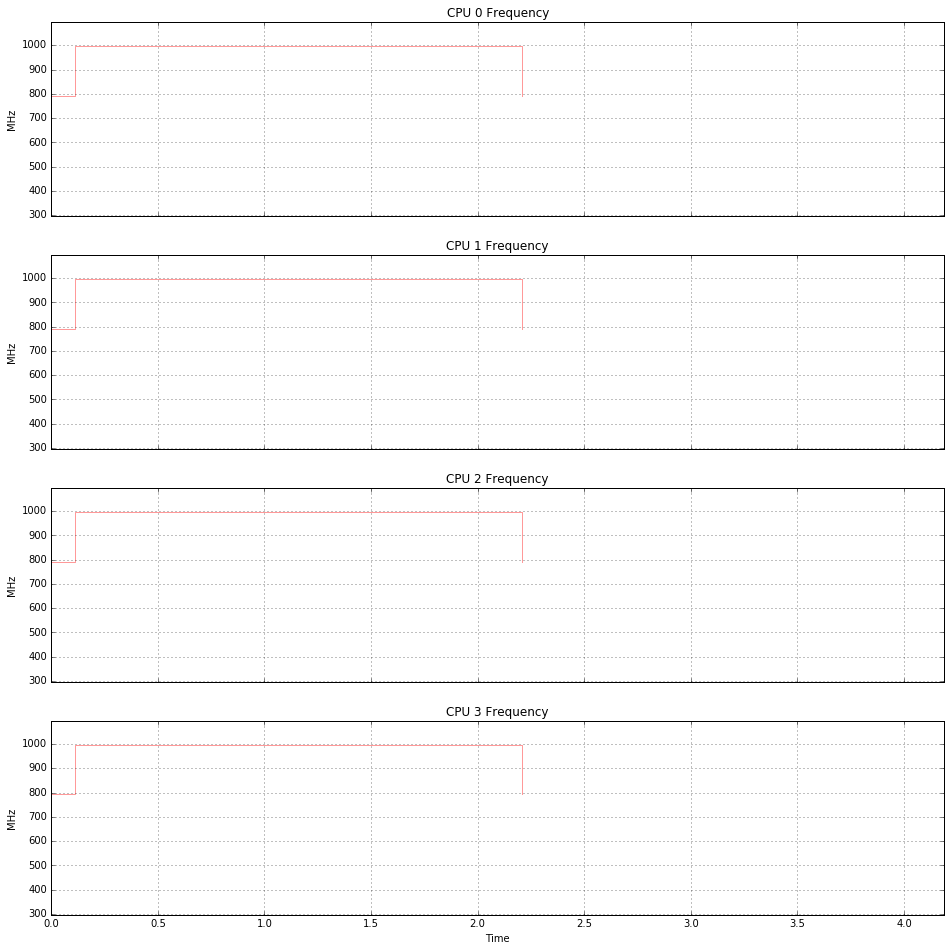

In [12]:
tr.analysis.frequency.plotCPUFrequencies()

### Plot execution

In [13]:
#tr.analysis.tasks.plotTasks()

In [14]:
df = tr.ftrace.sched_switch.data_frame
a = df[df['__comm'].str.contains('T00')][['__pid']]
pids_set=set([])
for i in a.index:
    pid = a.get_value(i, '__pid')
    #print "Adding pid ", pid
    if isinstance(pid, int):
        pids_set.add(pid)
pids_list=list(pids_set)
#print "Plotting pids: ", pids_list
trappy.plotter.plot_trace(host_res_dir, "", pids_list)

### Plot GRUB total and active bw

In [15]:
for i in range (0, cpu_number):
    try:
        trappy.ILinePlot(tr.ftrace,
                signals=[
                            "sched_dl_grub:total_bw:0x0,0x0,0xff",
                            "sched_dl_grub:running_bw:0x0,0xff,0x0",
                ],
                pivot="cpu_id",
                filters={"cpu_id": [i]},
                marker = '+',
                drawstyle='steps-post',
                per_line=1).view()
    except Exception, err:
        print "No data for cpu ", i, " ", err

""
""


""
""


""
""


""
""
